# Adaptive control using `ldsctrlest`

This demo will be more comprehensive than the others, bringing together all of `cleosim`'s main capabilities&mdash;electrode recording, optogenetics, and latency modeling&mdash;as well as introducing more sophisticated model-based feedback control. To achieve the latter, we will use the `ldsctrlest` Python bindings to the [`ldsCtrlEst` C++ library](https://stanley-rozell.github.io/lds-ctrl-est/).

Imports:

In [143]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import matplotlib.pyplot as plt
import cleosim

# numpy faster than cython for lightweight example
prefs.codegen.target = 'numpy'
np.random.seed(1856)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Network setup

As in the optogenetics example, we'll use a trivial network of a small neuron group biased by Poisson input spikes. Note that the opsin model is conductance-based and so depends on somewhat realistic membrane voltages. So, we'll use the exponential integrate-and-fire model, which maintains simplicity while modeling the upward membrane potential spike we need.

In [144]:
n = 10
ng = NeuronGroup(
    n,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) - Rm*I) / tau_m : volt
    I : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70 * mV,
    },
)
ng.v = -70 * mV

input_group = PoissonInput(ng, "v", n, 100 * Hz, 1 * mV)

net = Network(ng, input_group)

## Coordinates, stimulation, and recording

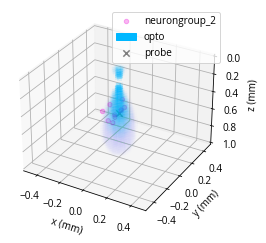

In [145]:
from cleosim.coordinates import assign_coords_rand_rect_prism, plot_neuron_positions

assign_coords_rand_rect_prism(ng, (-0.1, 0.1), (-0.1, 0.1), (0.4, 0.6))

from cleosim.opto import *
from cleosim.electrodes import Probe, SortedSpiking

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=four_state,
    opsin_params=ChR2_four_state,
    light_model_params=default_blue,
    location=(0, 0, 0.5) * mm,
)

spikes = SortedSpiking(
    "spikes",
    perfect_detection_radius=40 * umeter,
    half_detection_radius=80 * umeter,
    save_history=True,
)
probe = Probe(
    "probe",
    coords=[0, 0, 0.5] * mm,
    signals=[spikes],
)

plot_neuron_positions(
    ng,
    colors=["xkcd:fuchsia"],
    xlim=(-0.5, 0.5),
    ylim=(-0.5, 0.5),
    zlim=(0, 1),
    devices_to_plot=[opto, probe],
)


Looks right. Let's setup the simulation and inject the devices:

In [146]:
sim = cleosim.CLSimulator(net)
sim.inject_stimulator(opto, ng, Iopto_var_name='I')
sim.inject_recorder(probe, ng)

## Prepare controller
Our goal will be to control two neuron's firing rates simultaneously. To do this, we will use the adaptive linear technique explained in Bolus et al., 2021 ("State-space optimal feedback control of optogenetically driven neural activity").

### Fit model
Our controller needs a model of the system's dynamics, which we can obtain by fitting to training data. We will generate training data using Gaussian random walk inputs. `ldsCtrlEst` is designed for data coming from an experiment, organized into trials, so we will run the simulation repeatedly, resetting after each run. Here $u$ represents the input and $z$ the spike output.

The processing loop is simple enough here that we won't bother separating steps using `LoopComponent` objects, which is recommended for more complex scenarios where modularity is useful.

In [147]:
n_trials = 5
n_samp = 100
u = []
z = []
n_u = 1  # 1-dimensional input (just one optogenetic actuator)
n_z = 2  # we'll be controlling two neurons
for trial in range(n_trials):
    u.append(np.zeros((n_u, n_samp)))
    z.append(np.zeros((n_z, n_samp)))
    for k in range(1, n_samp):
        u_t = 0.975 * u[trial][:, k - 1] + 1e-1 * np.random.normal(size=n_u)
        # must be nonnegative
        u_t *= u_t >= 0
        u[trial][:, k] = u_t

from cleosim.processing import LatencyProcessingLoop

class FitLoop(LatencyProcessingLoop):
    i_samp = 0
    i_trial = 0

    # here we just feed in the training inputs and record the outputs
    def compute_ctrl_signal(self, state_dict, sample_time_ms):
        i, t, z_t = state_dict['probe']['spikes']
        z[self.i_trial][:, self.i_samp] = z_t[:2]  # just first two neurons
        out = {'opto': u[self.i_trial][:, self.i_samp]}
        self.i_samp += 1
        return out, sample_time_ms

fit_loop = FitLoop(sampling_period_ms=1)
sim.set_processing_loop(fit_loop)
sim.network.store()

for i_trial in range(n_trials):
    sim.network.restore()
    fit_loop.i_trial = i_trial
    fit_loop.i_samp = 0
    sim.run(n_samp*ms)

Now we have `u` and `z` in the form we need for `ldsctrlest`'s fitting functions: `n_trial`-length lists of `n` by `n_samp` arrays. We will now fit Gaussian linear dynamical systems using the SSID algorithm. See [the documentation](https://stanley-rozell.github.io/lds-ctrl-est/) for more detailed explanations.

In [148]:
import ldsctrlest as lds
import ldsctrlest.gaussian as glds
n_x_fit = 4  # latent dimensionality of system
n_h = 50  # size of block Hankel data matrix
dt = 0.001  # timestep (in seconds)
u_train = lds.UniformMatrixList(u, free_dim=2)
z_train = lds.UniformMatrixList(z, free_dim=2)
ssid = glds.FitSSID(n_x_fit, n_h, dt, u_train, z_train)
fit, sing_vals = ssid.Run(lds.SSIDWt.kMOESP)

### Design controller

We now use the fit parameters to create the controller system, add the parameters we need, then construct the controller.

In [149]:
ctrl_system = glds.System(fit)
u_lb = 0  # mW/mm2
u_ub = 30  # mW/mm2
controller = glds.Controller(ctrl_system, u_lb, u_ub)
controller.Print()


 ********** SYSTEM ********** 
x: 
        0
        0
        0
        0

P: 
   1.0000e-06            0            0            0
            0   1.0000e-06            0            0
            0            0   1.0000e-06            0
            0            0            0   1.0000e-06

A: 
  -0.9681   0.2233  -0.0067  -0.0142
  -0.2325  -0.9513  -0.0408   0.0548
   0.0343  -0.0038  -0.9350  -0.1868
   0.0366  -0.0313   0.1841  -0.7872

B: 
  -1.4612
   1.7521
   1.3884
   0.0949

g: 
   1.0000

m: 
        0
        0
        0
        0

Q: 
   0.0035   0.0006   0.0028  -0.0013
   0.0006   0.0074  -0.0019   0.0203
   0.0028  -0.0019   0.0045  -0.0155
  -0.0013   0.0203  -0.0155   0.3111

Q_m: 
   1.0000e-06            0            0            0
            0   1.0000e-06            0            0
            0            0   1.0000e-06            0
            0            0            0   1.0000e-06

d: 
        0
        0

C: 
   0.0235   0.1304  -0.1110   0.1850
  -0.0238 

In [150]:
class CtrlLoop(LatencyProcessingLoop):
    def __init__(self, samp_period_ms, controller, y_ref: callable):
        super().__init__(samp_period_ms)
        self.controller = controller
        self.sys = controller.sys
        self.y_ref = y_ref
        self.do_control = True
        self.u = []
        self.y_hat = []

    def compute_ctrl_signal(self, state_dict, sample_time_ms):
        i, t, z_t = state_dict['probe']['spikes']
        z_t = z_t[:2]  # again, just first two neurons
        self.controller.y_ref = self.y_ref(sample_time_ms)
        u_t = self.controller.ControlOutputReference(z_t, do_control=self.do_control)
        self.u.append(u_t)
        self.y_hat.append(self.sys.y)
        out = {'opto': u_t}
        return out, sample_time_ms + 0  # 3 ms delay

y_ref = np.ones((n_z, 1)) * 20 * dt  # target is 20 Hz firing
ctrl_loop = CtrlLoop(samp_period_ms=1, controller=controller, y_ref=lambda t: y_ref)

## Run the experiment

In [151]:
# run without control for 100 ms for comparison
sim.network.restore()
sim.set_processing_loop(ctrl_loop)
ctrl_loop.do_control = False
sim.run(100*ms)
ctrl_loop.do_control = True
sim.run(150*ms)

Now we plot the data to see how well the controller was able to match the desired firing rate:

[Text(0, 0.5, 'u (mW/mm$^2$)')]

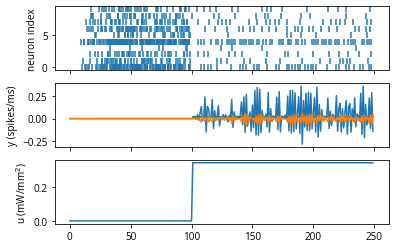

In [154]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.scatter(spikes.t_ms, spikes.i, marker='|')
ax1.set(ylabel='neuron index')
ax2.hlines(20*dt, 100, 250, color='green')
ax2.set(ylabel='y (spikes/ms)')
ax2.plot(np.array(ctrl_loop.y_hat).reshape((-1, 2)))
ax3.plot(range(250), np.array(ctrl_loop.u).reshape((-1)))
ax3.set(ylabel='u (mW/mm$^2$)')